# Multiclass Vegetable Classification Using Transfer Learning

This notebook uses a Keras InceptionV3 model, which is trained on more than 1M images from ImageNet database, and uses transfer learning for a new task of classifying vegetables from images.

The source of this notebook came from [Vegetable Classification Using Transfer Learning on Kaggle](https://www.kaggle.com/code/theeyeschico/vegetable-classification-using-transfer-learning) using the Vegetable Image Dataset and is an excellent source to learn this and other tutorials.

>Citation: Ahmed, M. Israk & Mamun, Shahriyar & Asif, Asif. (2021). DCNN-Based Vegetable Image Classification Using Transfer Learning: A Comparative Study. 235-243. 10.1109/ICCCSP52374.2021.9465499. 

# Setup

In [62]:
import os

# scratch directory is apart of the .gitignore to ensure it is not committed to git
%env SCRATCH=../scratch
scratch_path = os.environ.get("SCRATCH", "scratch")

env: SCRATCH=../scratch


In [63]:
# install dependencies
%pip install -q -U pip
%pip install -q -r requirements.txt

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [64]:
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display, Image
from PIL import Image
from PIL import ImageEnhance
from skimage.io import imread
import matplotlib.pyplot as plt

import os, random, pathlib, warnings, itertools, math

warnings.filterwarnings("ignore")

import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.metrics import confusion_matrix

from tensorflow.keras import models
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.layers import (
    Dense,
    Flatten,
    GlobalAveragePooling2D,
    Dense,
    Dropout,
)

K.clear_session()

# Load the data

In [65]:
# setup paths for data
dataset = scratch_path + "/Vegetable Images/"

train_folder = os.path.join(dataset, "train")
test_folder = os.path.join(dataset, "validation")
validation_folder = os.path.join(dataset, "test")

# Explore the data

Counting number of images in a folder. (test set in our case)

In [66]:
def count_files(rootdir):
    """counts the number of files in each subfolder in a directory"""
    for path in pathlib.Path(rootdir).iterdir():
        if path.is_dir():
            print(
                "There are "
                + str(
                    len(
                        [
                            name
                            for name in os.listdir(path)
                            if os.path.isfile(os.path.join(path, name))
                        ]
                    )
                )
                + " files in "
                + str(path.name)
            )

In [67]:
count_files(os.path.join(train_folder))

There are 1000 files in Capsicum
There are 1000 files in Radish
There are 1000 files in Pumpkin
There are 1000 files in Cauliflower
There are 1000 files in Potato
There are 1000 files in Bean
There are 1000 files in Cucumber
There are 1000 files in Brinjal
There are 1000 files in Cabbage
There are 1000 files in Broccoli
There are 1000 files in Bitter_Gourd
There are 1000 files in Papaya
There are 1000 files in Bottle_Gourd
There are 1000 files in Tomato
There are 1000 files in Carrot


Counting number of images in a folder. (test set in our case)

In [68]:
count_files(os.path.join(test_folder))

There are 200 files in Capsicum
There are 200 files in Radish
There are 200 files in Pumpkin
There are 200 files in Cauliflower
There are 200 files in Potato
There are 200 files in Bean
There are 200 files in Cucumber
There are 200 files in Brinjal
There are 200 files in Cabbage
There are 200 files in Broccoli
There are 200 files in Bitter_Gourd
There are 200 files in Papaya
There are 200 files in Bottle_Gourd
There are 200 files in Tomato
There are 200 files in Carrot


As evident, Dataset is well balanced with each class containing :
1000 images for training set.
200 images for test set.

# Image Proprocessing

The goal of image processing is improvement of pictorial information for human interpretation. Basic manipulation and filtering can lead to increased understanding for feature extraction as well.

We increase the color saturation, contrast and finally sharpened the image for drawing texture and viewer focus. The image after processing looks appealing and brighter

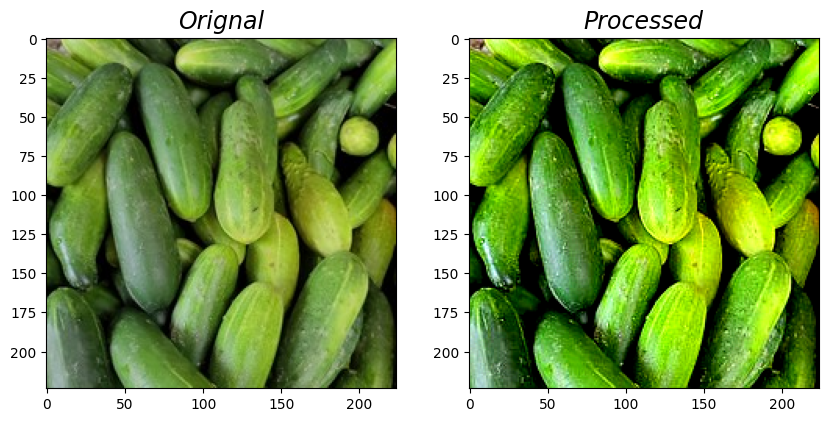

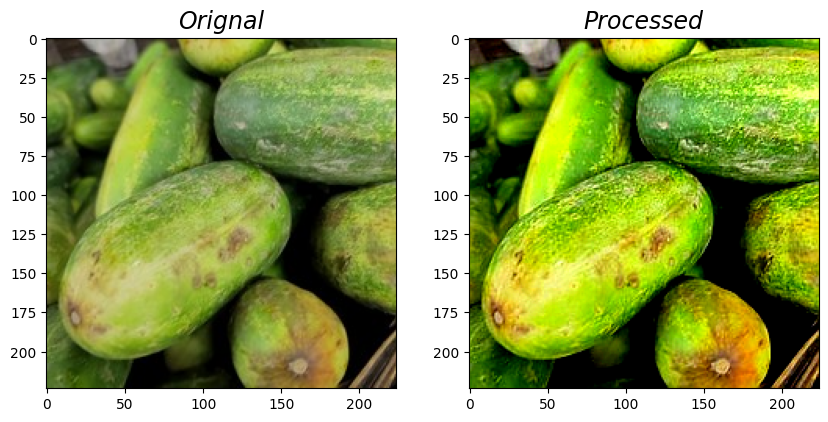

In [69]:
image_folder = "Cucumber"  # The vegetable you want to display
number_of_images = 2  # Number of images to display


def Preprocess():
    j = 1
    for i in range(number_of_images):
        folder = os.path.join(test_folder, image_folder)
        a = random.choice(os.listdir(folder))

        image = Image.open(os.path.join(folder, a))
        image_duplicate = image.copy()
        plt.figure(figsize=(10, 10))

        plt.subplot(number_of_images, 2, j)
        plt.title(label="Orignal", size=17, pad="7.0", loc="center", fontstyle="italic")
        plt.imshow(image)
        j += 1

        image1 = ImageEnhance.Color(image_duplicate).enhance(1.35)
        image1 = ImageEnhance.Contrast(image1).enhance(1.45)
        image1 = ImageEnhance.Sharpness(image1).enhance(2.5)

        plt.subplot(number_of_images, 2, j)
        plt.title(
            label="Processed", size=17, pad="7.0", loc="center", fontstyle="italic"
        )
        plt.imshow(image1)
        j += 1


Preprocess()

# Data Visualization

We can start exploring the dataset and visualize any class label (for instance, Capsicum). You can choose any vegetable to visualize the images of that class. Changing rows and columns variable also results in different format positioning of matplotlib.

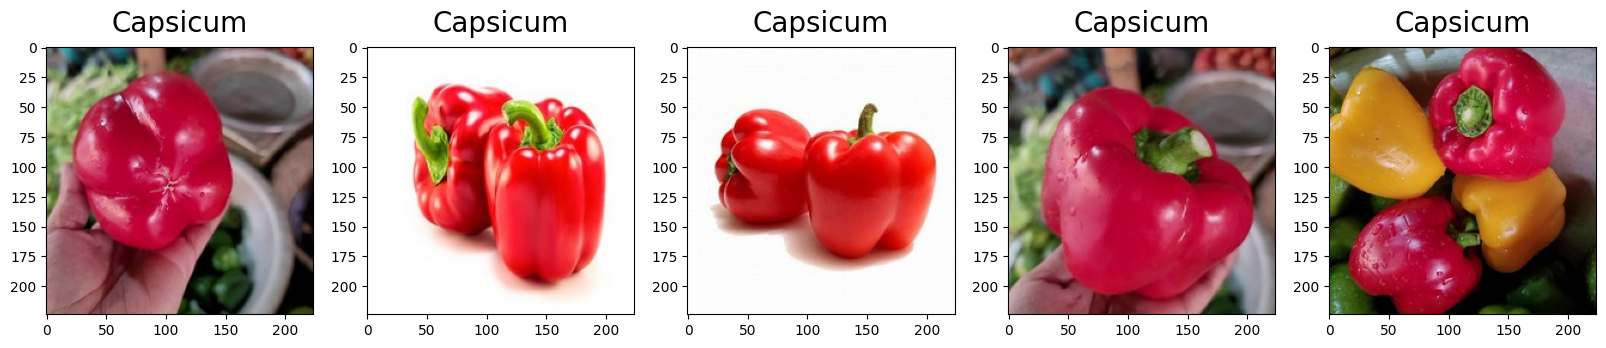

In [70]:
select_vegetable = "Capsicum"
rows, columns = 1, 5

display_folder = os.path.join(train_folder, select_vegetable)
total_images = rows * columns
fig = plt.figure(1, figsize=(20, 10))

for i, j in enumerate(os.listdir(display_folder)):
    img = plt.imread(os.path.join(train_folder, select_vegetable, j))
    fig = plt.subplot(rows, columns, i + 1)
    fig.set_title(select_vegetable, pad=11, size=20)
    plt.imshow(img)

    if i == total_images - 1:
        break

Now let's visualize the whole dataset by picking a random image from each class inside training dataset.

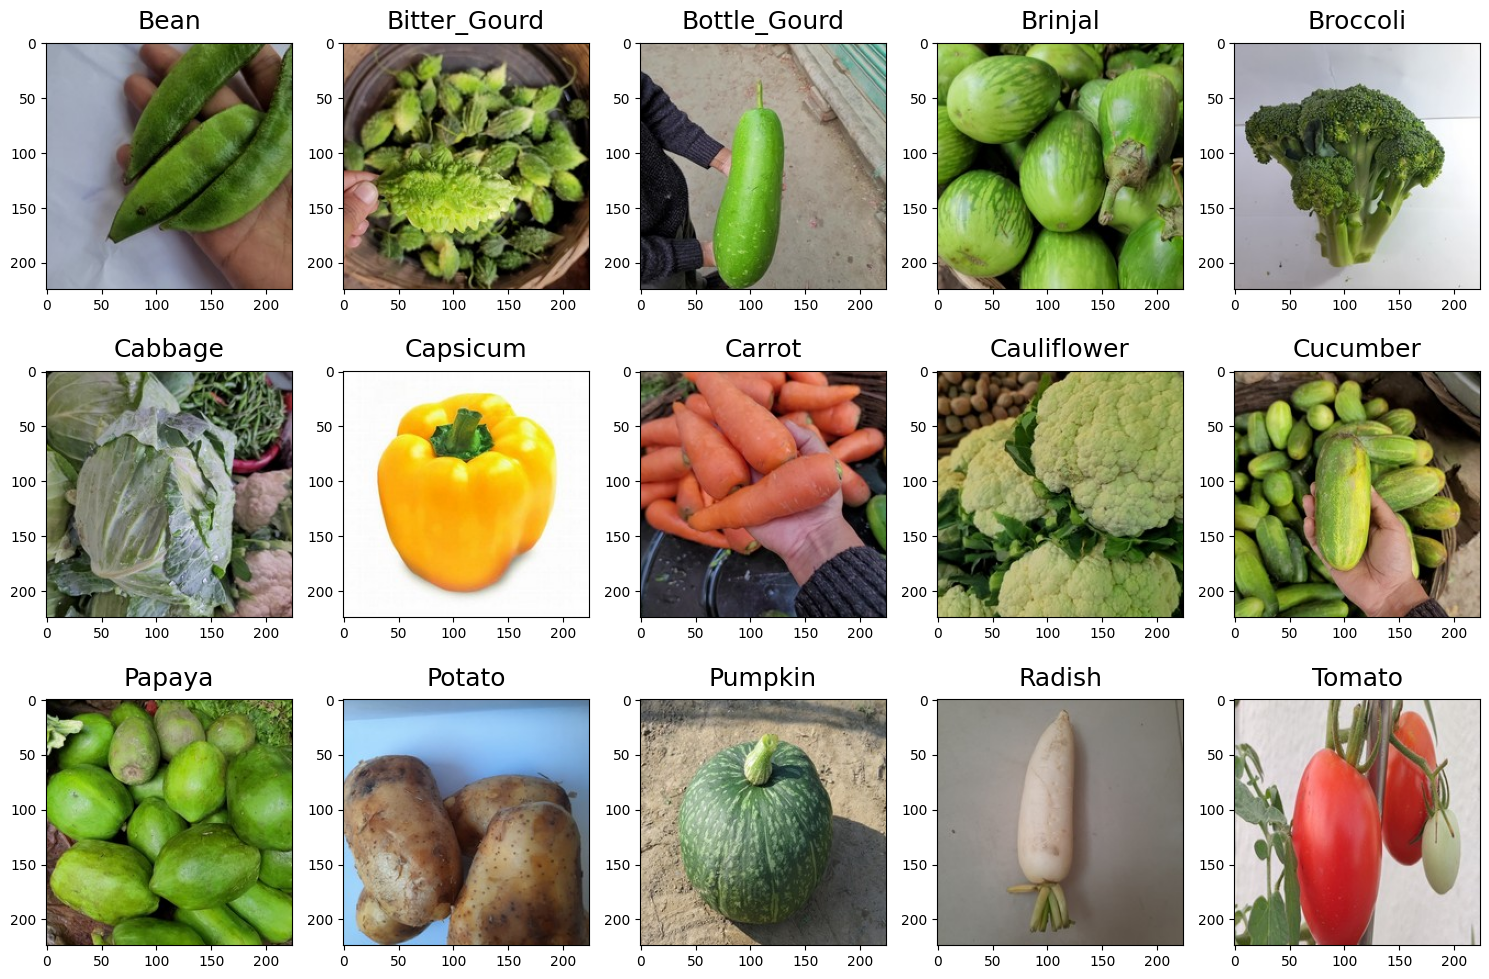

In [71]:
images = []

for food_folder in sorted(os.listdir(train_folder)):
    food_items = os.listdir(train_folder + "/" + food_folder)
    food_selected = np.random.choice(food_items)
    images.append(os.path.join(train_folder, food_folder, food_selected))

fig = plt.figure(1, figsize=(15, 10))

for subplot, image_ in enumerate(images):
    category = image_.split("/")[-2]
    imgs = plt.imread(image_)
    a, b, c = imgs.shape
    fig = plt.subplot(3, 5, subplot + 1)
    fig.set_title(category, pad=10, size=18)
    plt.imshow(imgs)

plt.tight_layout()

There are 15 vegetables (output classes) and one random image from each class helps in determining basic outlook of dataset and what picture quality along with different metric are visible. So far, So Good!

# Dataset preparation

In [72]:
# Generate batches of tensor image data with real-time data augmentation.
train_datagen = image.ImageDataGenerator(
    rescale=1.0 / 255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True
)

# Takes the path to a directory & generates batches of augmented data.
train_dataset = train_datagen.flow_from_directory(
    train_folder, target_size=(224, 224), batch_size=64, class_mode="categorical"
)

# Generate batches of tensor image data with real-time data augmentation.
test_datagen = image.ImageDataGenerator(rescale=1.0 / 255)

# Takes the path to a directory & generates batches of augmented data.
test_dataset = test_datagen.flow_from_directory(
    test_folder, target_size=(224, 224), batch_size=64, class_mode="categorical"
)

class_map = train_dataset.class_indices
print(class_map)

Found 15000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.
{'Bean': 0, 'Bitter_Gourd': 1, 'Bottle_Gourd': 2, 'Brinjal': 3, 'Broccoli': 4, 'Cabbage': 5, 'Capsicum': 6, 'Carrot': 7, 'Cauliflower': 8, 'Cucumber': 9, 'Papaya': 10, 'Potato': 11, 'Pumpkin': 12, 'Radish': 13, 'Tomato': 14}


# Model Building

Let's start building the transfer learning network to train our model using InceptionV3.

In [73]:
IMAGE_SIZE = [224, 224]

inception = InceptionV3(
    input_shape=IMAGE_SIZE + [3], weights="imagenet", include_top=False
)

for layer in inception.layers:
    layer.trainable = False

x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.2)(x)

prediction = Dense(15, activation="softmax")(x)

model = Model(inputs=inception.input, outputs=prediction)

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [74]:
class_map = train_dataset.class_indices
class_map

{'Bean': 0,
 'Bitter_Gourd': 1,
 'Bottle_Gourd': 2,
 'Brinjal': 3,
 'Broccoli': 4,
 'Cabbage': 5,
 'Capsicum': 6,
 'Carrot': 7,
 'Cauliflower': 8,
 'Cucumber': 9,
 'Papaya': 10,
 'Potato': 11,
 'Pumpkin': 12,
 'Radish': 13,
 'Tomato': 14}

# Model Training

In [75]:
model_metadata = "_inceptionV3_epoch5"
path_to_model = scratch_path + "/models/model" + model_metadata + ".h5"

In [76]:
if not os.path.exists(path_to_model):
    print("Model: Training...")
    history = model.fit_generator(
        train_dataset,
        validation_data=test_dataset,
        epochs=5,
        steps_per_epoch=len(train_dataset),
        validation_steps=len(test_dataset),
    )
    print("Model: Trained")

    print("Model: Saving...")
    model.save(path_to_model)
    print("Model: Saved")

else:
    print("Model: Already Exists")
    model = load_model(path_to_model)

Model: Already Exists


## Plot Accuracy and Loss

In [77]:
def plot_accuracy(history):
    plt.plot(history.history["accuracy"], label="train accuracy")
    plt.plot(history.history["val_accuracy"], label="validation accuracy")
    plt.title("Model accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(loc="best")
    plt.savefig("../reports/Accuracy_v1_InceptionV3")
    plt.show()


def plot_loss(history):
    plt.plot(history.history["loss"], label="train loss")
    plt.plot(history.history["val_loss"], label="validation loss")
    plt.title("Model loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(loc="best")
    plt.savefig("../reports/Loss_v1_InceptionV3")
    plt.show()

Scoring: ...


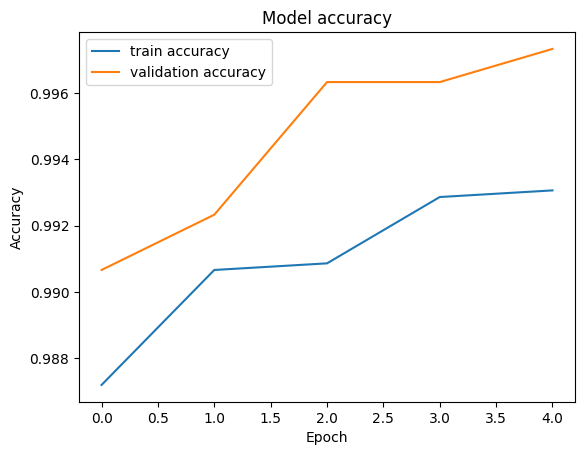

Scoring: ...


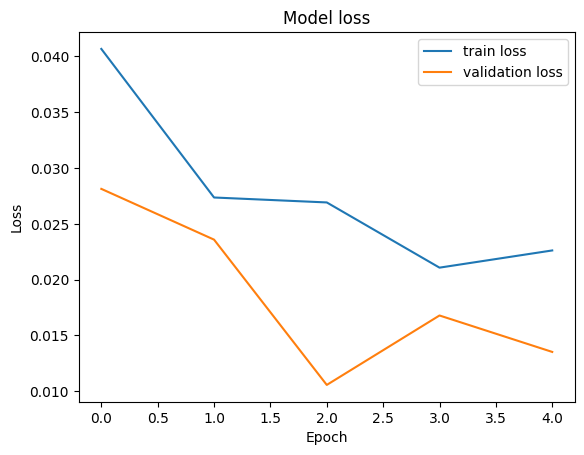

In [78]:
acc_plot = "../reports/Accuracy_v1_InceptionV3.png"
loss_plot = "../reports/Loss_v1_InceptionV3.png"

# display previously saved plots

try:
    display(Image(filename=acc_plot))
except:
    print("Scoring: ...")
    plot_accuracy(history)

try:
    display(Image(filename=loss_plot))
except:
    print("Scoring: ...")
    plot_loss(history)

## Visualize Model Layers

In [79]:
print("Total layers in the model : ", len(model.layers), "\n")

layers = [layer.output for layer in model.layers[0:]]
layer_names = []
for layer in model.layers[0:]:
    layer_names.append(layer.name)

print("First layer : ", layer_names[0])
print("InceptionV3 layers : Layer 2 to Layer 311")
print("Our fine tuned layers : ", layer_names[311:314])
print("Final Layer : ", layer_names[314])

Total layers in the model :  315 

First layer :  input_1
InceptionV3 layers : Layer 2 to Layer 311
Our fine tuned layers :  ['global_average_pooling2d', 'dense', 'dropout']
Final Layer :  dense_1


# Model Validation

## Load the model from storage

In [80]:
K.clear_session()

print("Model: Loading...")
model = load_model(path_to_model)
print("Model: Loaded")

Model: Loading...
Model: Loaded


## Testing the model

In [81]:
validation_data_dir = scratch_path + "/Vegetable Images/test"

validation_datagen = image.ImageDataGenerator(rescale=1.0 / 255)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir, target_size=(224, 224), batch_size=64, class_mode="categorical"
)

scores = model.evaluate_generator(validation_generator)
print("Test Accuracy: {:.3f}".format(scores[1]))

Found 3000 images belonging to 15 classes.


2023-06-28 23:37:59.082250: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-06-28 23:38:01.699991: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Test Accuracy: 0.996


## Confusion Matrix for evaluating the performance of our classification model

In [82]:
def labels_confusion_matrix(validation_folder):
    folder_path = validation_folder

    mapping = {}
    for i, j in enumerate(sorted(os.listdir(folder_path))):
        mapping[j] = i

    files = []
    real = []
    predicted = []

    for i in os.listdir(folder_path):
        true = os.path.join(folder_path, i)
        true = true.split("/")[-1]
        true = mapping[true]

        for j in os.listdir(os.path.join(folder_path, i)):
            img_ = image.load_img(
                os.path.join(folder_path, i, j), target_size=(224, 224)
            )
            img_array = image.img_to_array(img_)
            img_processed = np.expand_dims(img_array, axis=0)
            img_processed /= 255.0
            prediction = model.predict(img_processed)
            index = np.argmax(prediction)

            predicted.append(index)
            real.append(true)

    return (real, predicted)


def print_confusion_matrix(real, predicted):
    total_output_labels = 15
    cmap = "turbo"
    cm_plot_labels = [i for i in range(15)]

    cm = confusion_matrix(y_true=real, y_pred=predicted)
    df_cm = pd.DataFrame(cm, cm_plot_labels, cm_plot_labels)
    sns.set(font_scale=1.2)  # for label size
    plt.figure(figsize=(15, 10))
    s = sns.heatmap(df_cm, fmt="d", annot=True, cmap=cmap)  # font size

    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.savefig(scratch_path + "/confusion_matrix.png")
    plt.show()

In [83]:
%%capture

y_true, y_pred = labels_confusion_matrix(validation_folder)

2023-06-28 23:38:46.157895: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [ ]:
##TODO make this an if else to load the .png if a model exists
print_confusion_matrix(y_true, y_pred)

The false positives are really low as we have used transfer learning which has given us good accuracy!

# Prediction in Notebook

## Function to predict output of our model

In [ ]:
category = {
    0: "Bean",
    1: "Bitter_Gourd",
    2: "Bottle_Gourd",
    3: "Brinjal",
    4: "Broccoli",
    5: "Cabbage",
    6: "Capsicum",
    7: "Carrot",
    8: "Cauliflower",
    9: "Cucumber",
    10: "Papaya",
    11: "Potato",
    12: "Pumpkin",
    13: "Radish",
    14: "Tomato",
}


def predict_image(filename, model):
    img_ = image.load_img(filename, target_size=(224, 224))
    img_array = image.img_to_array(img_)
    img_processed = np.expand_dims(img_array, axis=0)
    img_processed /= 255.0

    prediction = model.predict(img_processed)
    index = np.argmax(prediction)

    plt.title("Prediction - {}".format(category[index]))
    plt.imshow(img_array)


def predict_dir(filedir, model):
    cols = 3
    pos = 0
    images = []
    total_images = len(os.listdir(filedir))
    rows = total_images // cols + 1

    true = filedir.split("/")[-1]

    for i in sorted(os.listdir(filedir)):
        images.append(os.path.join(filedir, i))

    for subplot, imggg in enumerate(images):
        img_ = image.load_img(imggg, target_size=(224, 224))
        img_array = image.img_to_array(img_)
        img_processed = np.expand_dims(img_array, axis=0)
        img_processed /= 255.0
        prediction = model.predict(img_processed)
        index = np.argmax(prediction)

        pred = category.get(index)
        if pred == true:
            pos += 1

    acc = pos / total_images
    print(
        "Accuracy for {orignal}: {:.2f} ({pos}/{total})".format(
            acc, pos=pos, total=total_images, orignal=true
        )
    )

## Single image prediction

In [ ]:
predict_image(os.path.join(validation_folder, "Cauliflower/1064.jpg"), model)

## Directory of images predictions

## Visualize incorrect predictions
Visualizing all incorrect images predicted for a particular vegetable category by our classifier.

In [ ]:
def wrong_input_capture(test_category):
    a = os.path.basename(test_category)
    wrong_array = []

    for i in os.listdir(test_category):
        imggg = os.path.join(test_category, i)

        img_ = image.load_img(imggg, target_size=(224, 224))
        img_array = image.img_to_array(img_)
        img_processed = np.expand_dims(img_array, axis=0)
        img_processed /= 255.0
        prediction = model.predict(img_processed)

        index = np.argmax(prediction)
        pred = category.get(index)

        if not pred == a:
            wrong_array.append((imggg, pred))

    return wrong_array


def visualize_wrong_input(images):
    fig = plt.figure(1, figsize=(20, 25))
    total_images = len(images)
    rows = math.ceil(float(total_images / 3))
    for subplot, (image_path, predicted) in enumerate(images):
        img = plt.imread(image_path)
        fig = plt.subplot(rows, 3, subplot + 1)
        fig.set_title("Predicted - {}".format(predicted), pad=10, size=18)
        plt.imshow(img)

    plt.tight_layout()

In [ ]:
%%capture

vegetable = "Broccoli"
path = os.path.join(validation_folder, vegetable)
images = wrong_input_capture(path)

In [ ]:
visualize_wrong_input(images)